In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
sns.set(rc={'figure.figsize':(15, 10)})

# Načítavanie dát

Do premenných `train` a `test` si načítame trénovacie a testovacie údaje, ktoré sme si uložili vo fáze 2.

In [2]:
train = pd.read_csv('data/train.csv', index_col=0)
test = pd.read_csv('data/test.csv', index_col=0)

Vytvoríme si pre každý z vybraných parametrov a vykreslíme si ho, pričom si hodnoty farebne rozdelíme podľa atribútu `indicator`. V scatterplotoch nevidíme výrazné rozdiely, aj keď pri premenných `2` a `3` môžeme pozorovať rozdelenie bodov na dve časti.

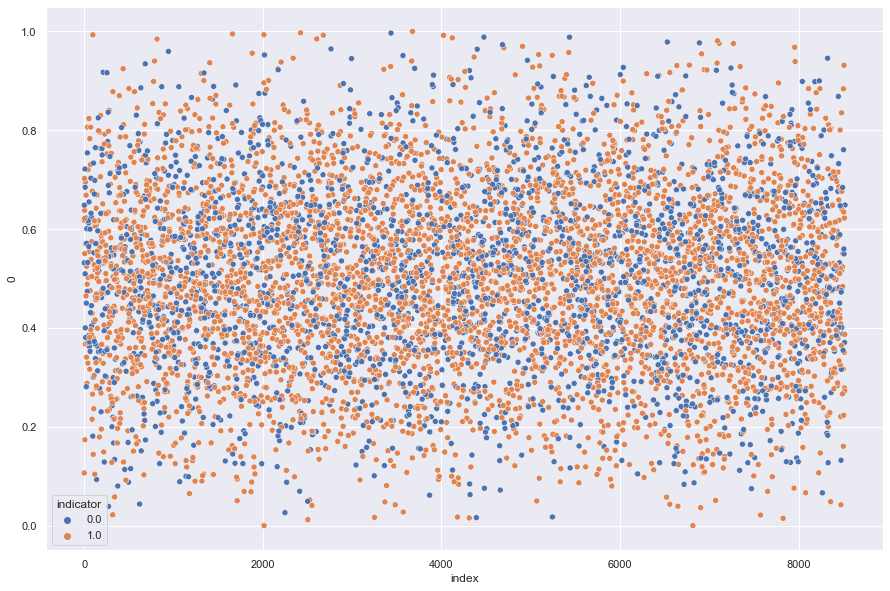

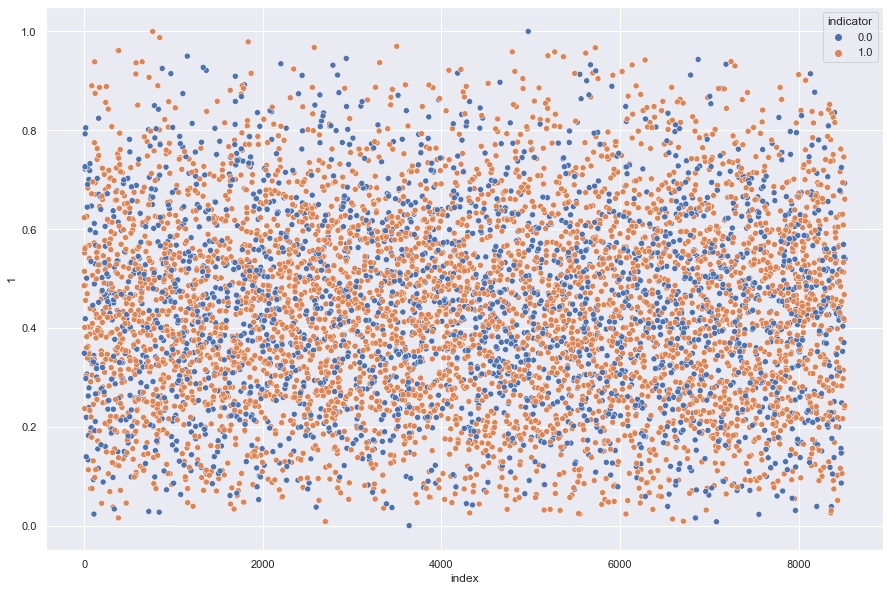

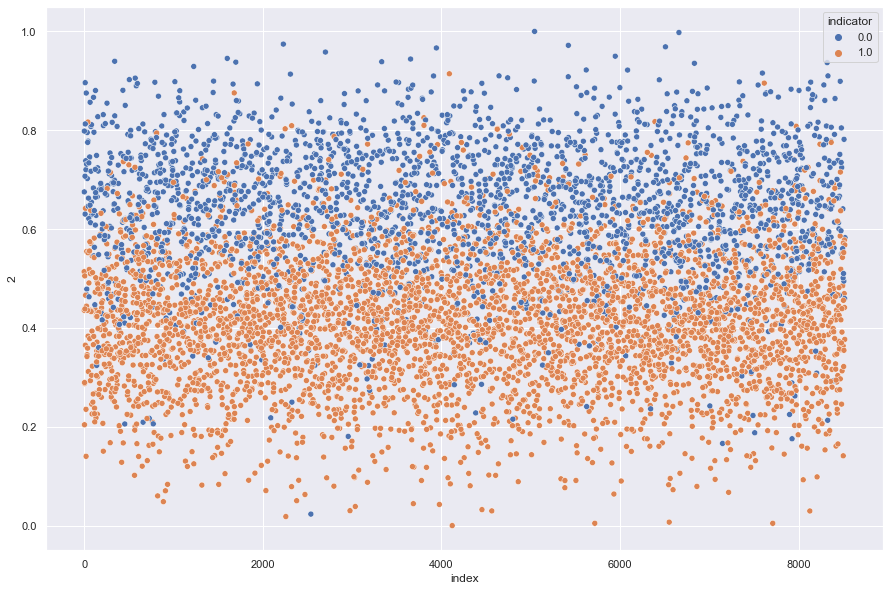

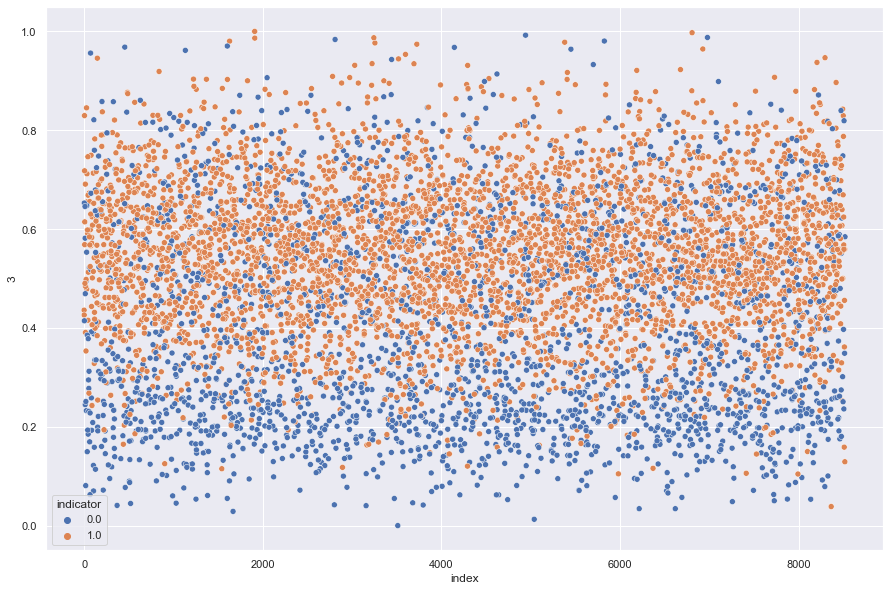

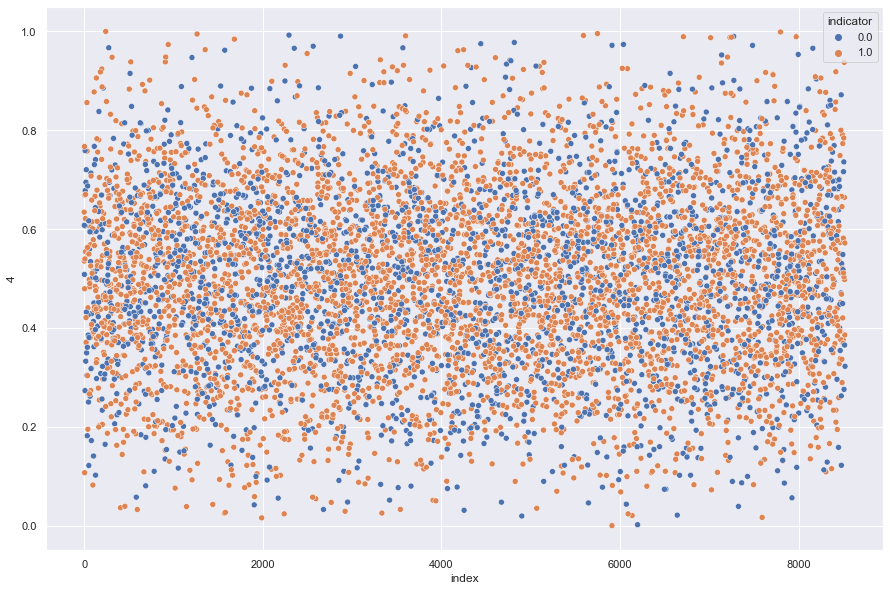

In [3]:
for i in range (5):
    sns.scatterplot(data=train.reset_index(), x='index', y=str(i), hue='indicator')
    plt.show();

Pre lepšiu vizualizáciu skúsime použiť kernel density estimation grafy, a teraz môžeme zreteľne vidieť, že premenné `2` a `3` nadobúdajú rozdielne hodnoty keď je indikátor 0 a keď je 1.

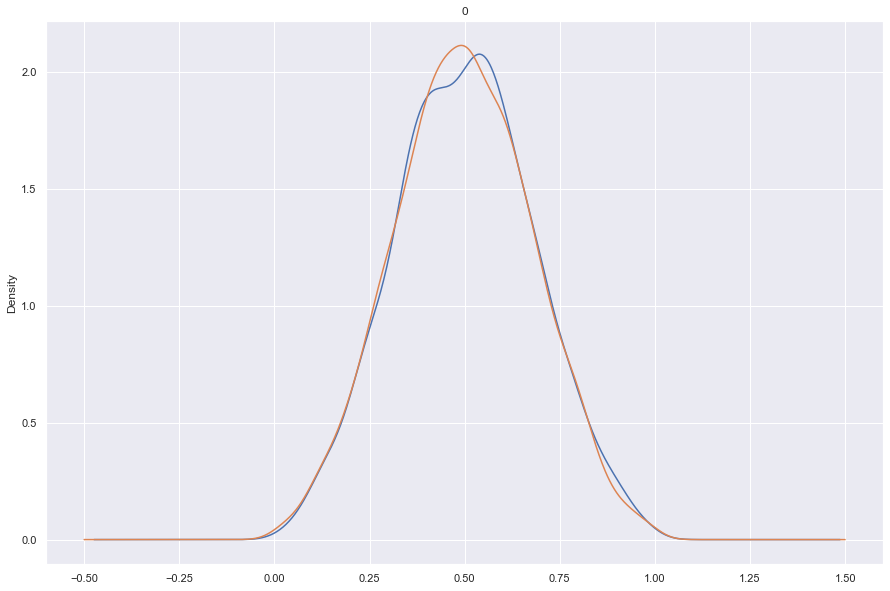

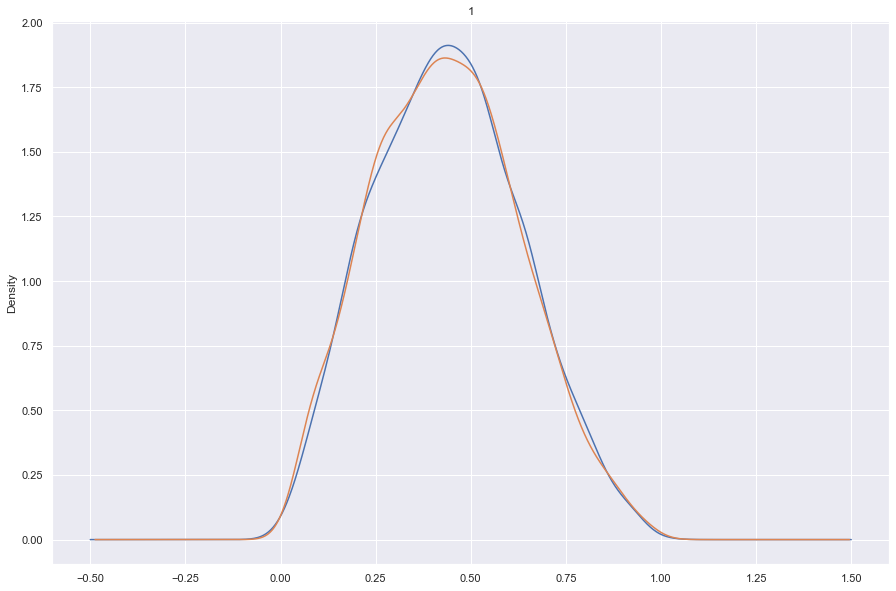

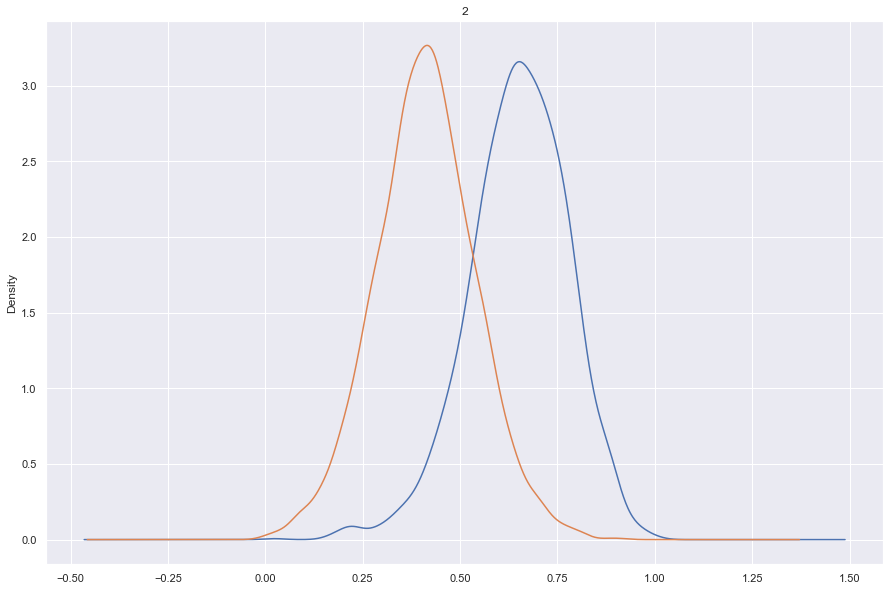

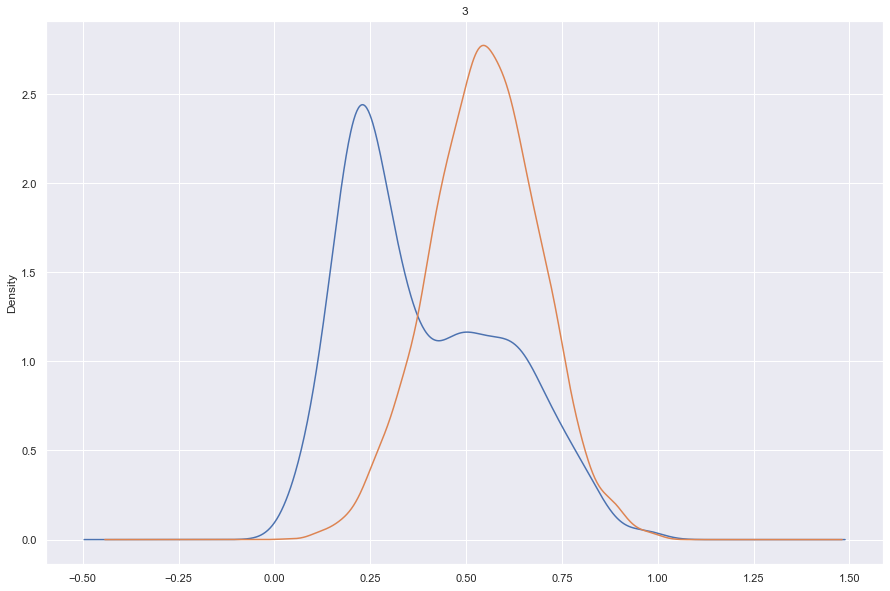

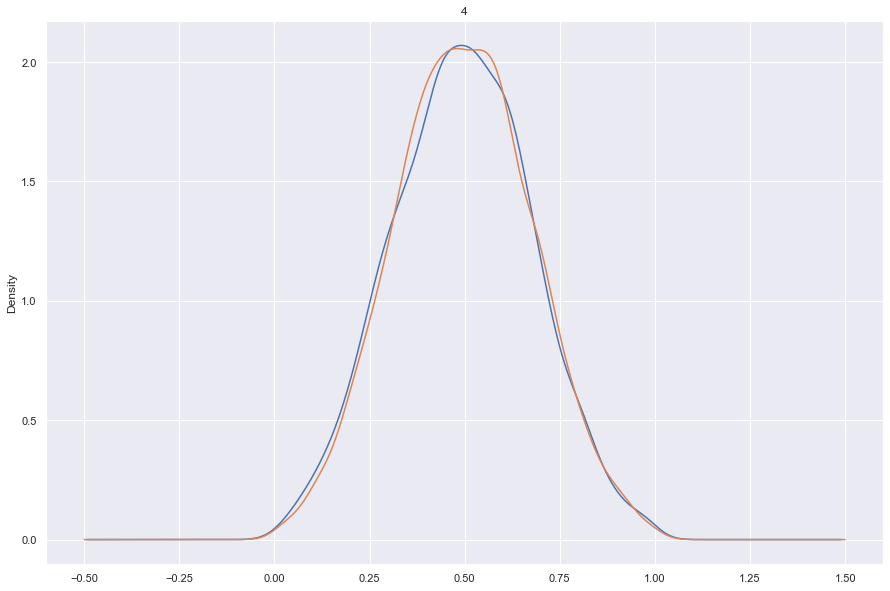

In [4]:
for i in range (5):
    train.groupby('indicator')[str(i)].plot(kind='kde')
    plt.title(i)
    plt.show();

Dáta síce máme rozdelené na trénovaciu a testovaciu množinu, ale máme všetky hodnoty v jednej tabuľke. Pre správne trénovanie modelu potrebujeme rozdeliť tabuľku na X (všetky trénovacie hodnoty) a y (predikované hodnoty, labels).

In [5]:
X_train, y_train = train.iloc[:, :-1], train.iloc[:, -1]
X_test, y_test = test.iloc[:, :-1], test.iloc[:, -1]
X_train

,0,1,2,3,4
6289,0.442702,0.395137,0.538920,0.586982,0.496804
549,0.332474,0.134210,0.450919,0.758853,0.479178
4707,0.770363,0.290815,0.436752,0.685388,0.826102
764,0.379951,0.649711,0.629717,0.249821,0.397311
6861,0.209590,0.318906,0.674777,0.586803,0.569239
...,...,...,...,...,...
5734,0.708144,0.554586,0.195417,0.651323,0.667740
5191,0.396380,0.950776,0.323932,0.634696,0.454430
5390,0.364240,0.594460,0.433011,0.641636,0.424734
860,0.364191,0.295530,0.176978,0.622511,0.421941


# One-rule algoritmus

Najprv skúsime vytvoriť vlasntý prediktor hodnoty `indicator` na základe pevne stanovených pravidiel. Kedže najvýraznejšie rozdiely sme mohli pozorovať pri atribútoch `2` a `3`, použijeme tieto premenné vo funkcii `one_rule(row)`. 

1R algoritmus zvyčajne predikuje výsledok na základe jednej premennej, ale my sme sa ho rozhodli jemne zlepšiť a rozšíriť, nakoľko pri ňom pracujeme s dvoma atribútmi. Pevnú hranicu si stanovíme podľa kernel density estimation grafov vyššie, konkrétne podľa miesta, kde sa graf s indikátorom 0 pretína s grafom s indikátorom 1. To sa dá približne určiť ako priemerná hodnota priemeru atribútu s indikátorom 1 a priemeru atribútu s indikátorom 0. V našom prípade sme použili atribúty `2` a `3`, pričom atribút `2` má hranicu približne v 0.50 a `3` v 0.40.

Pre každú kombináciu atribútov vrátime výsledok, pričom kladieme väčší význam atribútu `2`, nakoľko má lepšie viditeľný priesečník grafov a zároveň grafy vyzerajú byť z normálneho rozdelenia, na rozdiel od atribútu `3`.

In [6]:
def one_rule(data):
    a2 = data.loc[data.indicator == 1, '2']
    b2 = data.loc[data.indicator == 0, '2']

    a3 = data.loc[data.indicator == 1, '3']
    b3 = data.loc[data.indicator == 0, '3']

    interp_2 = (a2.mean() + b2.mean()) / 2
    interp_3 = (a3.mean() + b3.mean()) / 2

    result = []

    for index, row in data.iterrows():
        if row['2'] < interp_2 and row['3'] >= interp_3:
            result.append(1)
        elif row['2'] < interp_2 and row['3'] < interp_3:
            result.append(1)
        elif row['2'] >= interp_2 and row['3'] < interp_3:
            result.append(0)
        elif row['2'] >= interp_2 and row['3'] >= interp_3:
            result.append(0)

    return result

Funkcionalitu `one_rule()` aplikujeme na trénovaciu množinu a výsledok si uložíme do premennej `predict`. Pomocou `.head()` si vypíšeme prvých 5 predikovaných hodnôt a vidíme že sa nám do nich pekne uložila predikovaná hodnota - `indicator`.

In [7]:
pred = one_rule(train)
pred[:5]

[0, 1, 1, 0, 0]

Po uložení predikovaných hodnôt si pomocou `sklearn.metrics` a funkcií `accuracy_score`, `recall_score`, a `precision_score` zistíme úspešnosť predikovania indikátorov našim modelom porovnaním s reálnymi hodnotami indikátoru v testovacej množine.

### Accuracy
Accuracy, alebo presnosť, predstavuje mieru správnosti merania, teda koľko pozorovaní bolo správne označených za pozitívne a negatívne v testovanej množine. Túto metriku možno získať použitím vzorca:

$Accuracy=\frac{TP+TN}{TP+FP+TN+FN}$

TP je pravé pozitívum (jednotka je tam kde mala byť), TN je pravé negatívum (nula je tam kde mala byť) a FP a FN sú falošné pozitíva a negatíva. Vo všeobecnosti platí, že čím vyššia presnosť, tým lepší model, ale samozrejme model s presnosťou 100% pravdepodobne overfittuje a vôbec nie je dobrým modelom. To sa však dá overiť ďalšími metrikami a aj grafmi.

### Precision
Precision, alebo precíznosť, je pomer pravých pozitív a súčtu všetkých pozitív, teda aj falošných, v testovanej množine. Vysoká precíznosť naznačuje nízku pravdepodobnosť falošných pozitív. 

$Precision=\frac{TP}{TP+FP}$


### Recall
Recall, alebo aj citlivosť, je pomer pravých pozitív a súčtu pravých pozitív a falošných negatív. Recall napovedá, koľko pozorovaní z testovanej množiny sme správne označili za pozitíva.

$Recall=\frac{TP}{TP+FN}$

Náš model má relatívne vysokú precíznosť a presnosť 83% nie je najhoršia, ale môže byť oveľa lepšia.

In [8]:
from sklearn.metrics import accuracy_score, recall_score, precision_score

print('Accuracy:', accuracy_score(y_train, pred))
print('Precision:', precision_score(y_train, pred))
print('Recall:', recall_score(y_train, pred))

Accuracy: 0.8324038743762842
Precision: 0.9047263681592039
Recall: 0.8273430391264787


# Rozhodovací strom

Urobme si teraz klasifikátor pomocou rozhodovacieho stromu za pomoci `DecisionTreeClassifier` pričom si určíme maximálnu hĺbku stromu 3 a `random_state=0`, aby sme vedeli replikovať ten istý výsledok. 

Natrénovaný rozhodovací strom si dáme vykresliť a môžeme pozorovať, že sme sa rozhodli správne, keď sme v 1R algoritme predikovali na základe atribútov `2` a `3`. Všetky rozhodnutia v tomto strome boli na základe týchto dvoch atribútov, aj keď samozrejme hranice rozhodovania boli precíznejšie a komplexnejšie ako pri 1R.

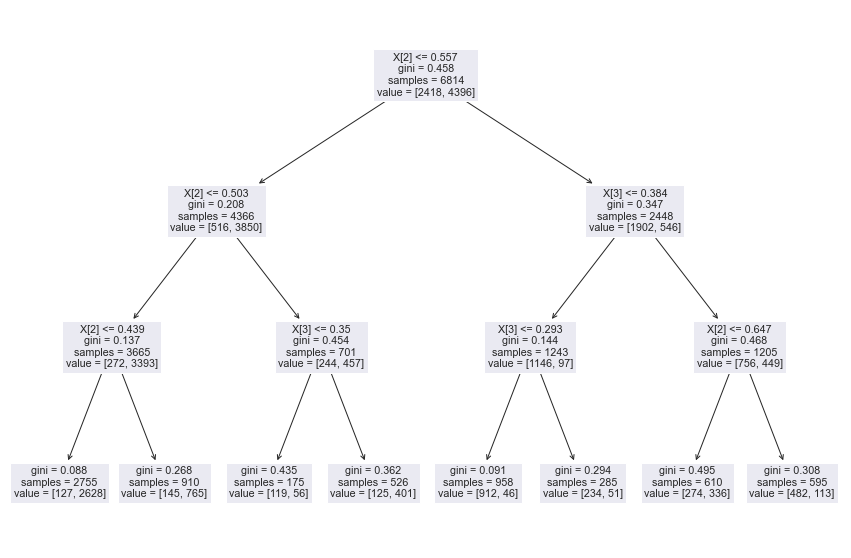

In [9]:
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

clf = DecisionTreeClassifier(max_depth=3, random_state=0)
clf.fit(X_train, y_train)
tree.plot_tree(clf);

#### Vyhodnotenie DecisionTreeClassification modelu:

Urobíme si predikciu daného klasifikátora podľa rozhodovacieho stromu a vidíme, že hodnoty presnosť a recall sú vyššie ako nami vytvorený jednoduchý 1R klasifikátor, pričom recall presiahol 90%. Naopak, rozhodovací strom vykazuje nižšiu precíznosť ako 1R algoritmus.

In [10]:
pred = clf.predict(X_test)

print('Accuracy:', accuracy_score(y_test, pred))
print('Precision:', precision_score(y_test, pred))
print('Recall:', recall_score(y_test, pred))

Accuracy: 0.8503521126760564
Precision: 0.8565292096219931
Recall: 0.9188940092165898


Urobíme si cross-validáciu, pri ktorej môžeme pozorovať, že skóre sa pohybuje okolo 85% so štandardnou odchýlkou 2%. To je celkom dobrý výsledok, aj keď samozrejme može byť oveľa lepší.

In [11]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(clf, X_test, y_test, cv=10)
print("Presnost %0.2f so standardnou odchylkou %0.2f" % (scores.mean(), scores.std()))

Presnost 0.85 so standardnou odchylkou 0.02


Teraz si môžeme vyskúšať, či zmena hĺbky stromu nezlepší presnosť modelu. Natrénujeme si 30 modelov s hĺbkami od 1 do 30 a porovnáme presnosť na trénovacej s testovacou množinou. Chybovosť trénovacej množiny klesá, čo je očakávané, ale od hĺbky 20 môžeme pozorovať, že chybovosť je takmer nulová, čo nám napovedá, že nastáva overfitting.

Zaujímavosťou je, že síce chyba na trénovacej množine klesá, na testovacej klesá iba po maximálnu hĺbku 4, a potom začne opäť stúpať. Model, ktorý sme si teda natrénovali ako prvý s maximálnou hĺbkou 3 nebol až tak zlý, aj keď samozrejme presnosť môže byť stále lepšia.

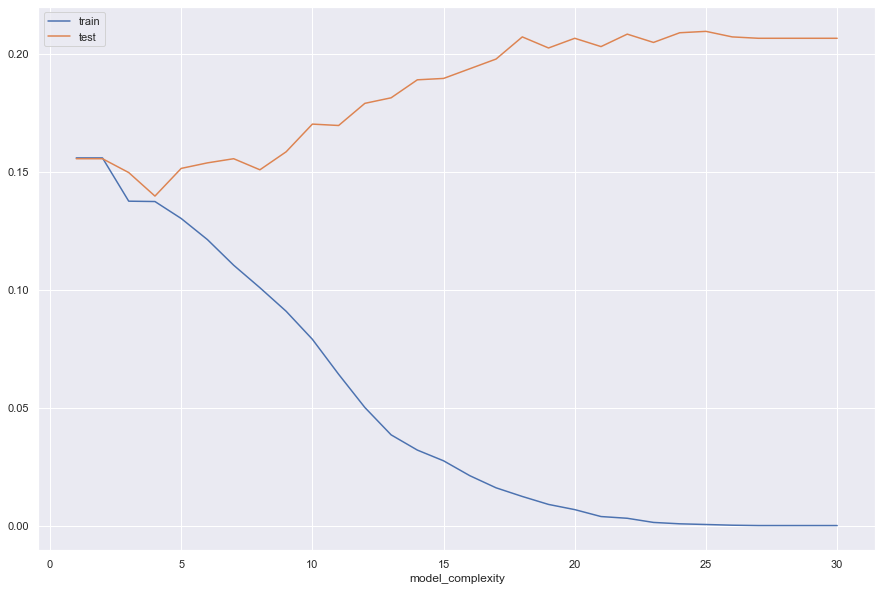

In [12]:
results = []
estimators = []
for i in range(1, 31):  
    row = {'model_complexity': i}
    clf = DecisionTreeClassifier(max_depth = i, random_state=0) 
    
    pred = clf.fit(X_train, y_train).predict(X_train) 
    row['train'] = 1 - accuracy_score(y_train, pred) 
    
    pred = clf.predict(X_test)
    row['test'] = 1 - accuracy_score(y_test, pred) 
    results.append(row)
    estimators.append(clf)

complexity_df = pd.DataFrame(results).plot(x='model_complexity')

Následne môžeme vyskúšať `GridSearchCV` na dôkladné preskúmanie rôznych kombinácií parametrov aby sme našli najlepší možný model. Vyskúšame kombinácie hodnotiaceho kritéria, spôsobu delenia stromu a maximálnej hĺbky. `GridSearch` potvrdil, že najlepšia hĺbka je 3, s kritériom gini a delením podľa najlepšieho, čo sú zároveň aj prednastavené možnosti pri rozhodovacích stromoch.

In [13]:
from sklearn.model_selection import GridSearchCV

parameters = {'criterion': ['gini', 'entropy'],
              'splitter': ['best', 'random'],
              'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]}

dtc = DecisionTreeClassifier()
clf = GridSearchCV(dtc, parameters, scoring='accuracy', cv=5)
clf.fit(X_train, y_train)

clf.best_params_

{'criterion': 'gini', 'max_depth': 3, 'splitter': 'best'}

# Random Forest

Ak chceme vylepšiť presnosť, môžeme skúsiť klasifikovanie pomocou `RandomForestClassifier`, čo je viacero náhodne vygenerovaných stromov, z náhodných podmnožín trénovacej množiny. Následne sa výsledky spriemerujú, čo vylepšuje presnosť a pôsobí ako prevencia pred overfittingom.

In [14]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(max_depth=3, random_state=42)
rfc.fit(X_train, y_train)
pred = rfc.predict(X_test)

print('Accuracy:', accuracy_score(y_test, pred))
print('Precision:', precision_score(y_test, pred))
print('Recall:', recall_score(y_test, pred))

Accuracy: 0.8615023474178404
Precision: 0.8934198331788693
Recall: 0.8884792626728111


Môžeme vidieť, že použitie `RandomForest` klasifikátora presnosť veľmi nevylepšuje. Môžeme si spraviť cross-validáciu, ale výsledné skóre sú približne rovnaké ako pri rozhodovacom strome. Môžeme ešte vyskúšať viacero maximálnych hĺbok stromov, kde už môžeme vidieť mierne zlepšenie, ale iba do hĺbky 2. Následne je chybovosť testovacej množiny približne konštantná.

In [15]:
scores = cross_val_score(rfc, X_test, y_test, cv=10)
print("Presnost %0.2f so standardnou odchylkou %0.2f" % (scores.mean(), scores.std()))

Presnost 0.86 so standardnou odchylkou 0.02


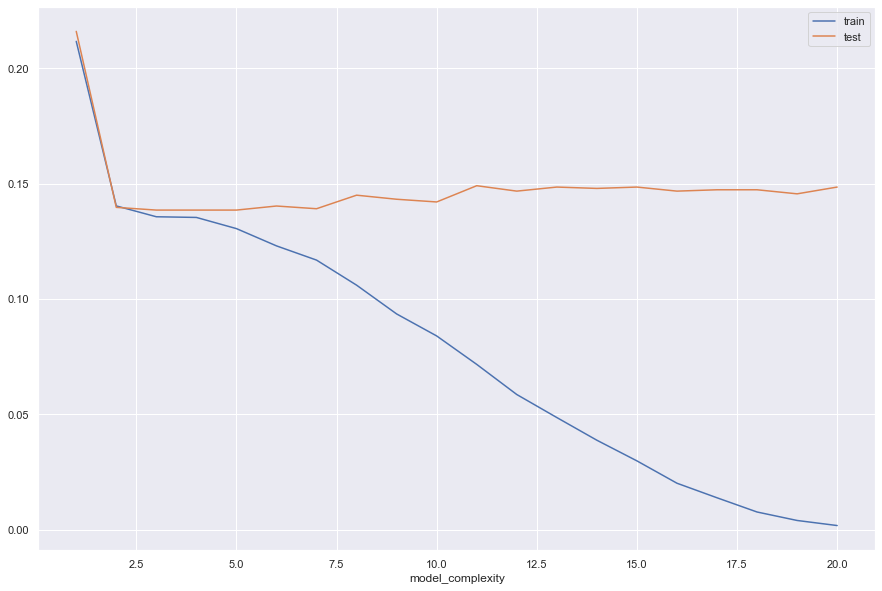

In [16]:
results = []
estimators = []
for i in range(1, 21):  
    row = {'model_complexity': i}
    rfc = RandomForestClassifier(max_depth = i, random_state=42) 

    pred = rfc.fit(X_train, y_train).predict(X_train) 
    row['train'] = 1 - accuracy_score(y_train, pred) 
    
    pred = rfc.predict(X_test)
    row['test'] = 1 - accuracy_score(y_test, pred) 
    results.append(row)
    estimators.append(rfc)
    
complexity_df = pd.DataFrame(results).plot(x='model_complexity')

Opäť teda skúsime použiť `GridSearchCV`. Ako parametre určíme bootstrap, ktorý určuje či sa použijú vzorky alebo celý dataset na tvorbu stromov, criterion, teda funkciu merania kvality rozhodnutia, maximálnu hĺbku a počet stromov v lese. Tentokrát `GridSearch` vyhodnotí, že najlepšie výsledky vrátil klasifikátor bez bootstrap, entropy funkciou, maximálnou hĺbkou 5 a počtom stromov 100.

In [17]:
parameters = {'bootstrap': [True, False],
              'criterion': ['gini', 'entropy'],
              'max_depth': [1, 2, 3, 4, 5],
              'n_estimators': [100, 400, 1000]}

rfc = RandomForestClassifier()
clf = GridSearchCV(rfc, parameters, scoring='accuracy', cv=5)
clf.fit(X_train, y_train)

clf.best_params_

{'bootstrap': False,
 'criterion': 'entropy',
 'max_depth': 5,
 'n_estimators': 100}

Napriek tomu môžeme vidieť, že metriky sa zlepšili iba minimálne a ani jedna nepresiahla 90%. Vyskúšame teda cross-validáciu, ale vidíme, že výsledky sú rovnaké ako pri pôvodnom `RandomForest` klasifikátore.

In [18]:
pred = clf.best_estimator_.predict(X_test)

print('Accuracy:', accuracy_score(y_test, pred))
print('Precision:', precision_score(y_test, pred))
print('Recall:', recall_score(y_test, pred))

Accuracy: 0.8573943661971831
Precision: 0.8635578583765112
Recall: 0.9216589861751152


In [19]:
scores = cross_val_score(clf.best_estimator_, X_test, y_test, cv=10)
print("Presnost %0.2f so standardnou odchylkou %0.2f" % (scores.mean(), scores.std()))

Presnost 0.86 so standardnou odchylkou 0.03


# Porovnanie natrénovaných klasifikátorov s one-rule algoritmom

-> **V nami manuálne vytvorenými pravidlami (one-rule)** sme dostali nasledovné hodnoty:

**Accuracy**: 0.8324038743762842
**Precision**: 0.9047263681592039
**Recall**: 0.8273430391264787

->**podľa DecisionTreeClassifier** natrénovaný klasifikátor dostal nasledovné hodnoty:

**Accuracy**: 0.8503521126760564
**Precision**: 0.8565292096219931
**Recall**: 0.9188940092165898

->**podľa RandomForestClassifier** natrénovaný klasifikátor dostal nasledovné hodnoty:

**Accuracy**: 0.8615023474178404
**Precision**: 0.8934198331788693
**Recall**: 0.8884792626728111

Vídime že **RandomForestClassifier** má najvyššiu presnosť, **DecisionTreeClassifier** má najlepší recall a **one-rule** zase najlepšiu precíznosť. Rozdiely sú však veľmi malé a nepodarilo sa nám zvýšiť presnosť nad 90%

# Experiment so všetkými dátami

V minulej fáze sme si uložili aj čisté pripravené dáta do súboru clean.csv, teraz si ich znovu načítame do premennej `clean` a skúsime si urobiť predikciu aj na tomto čistom datasete a pozrieme sa, či nedostaneme lepšie výsledky.

In [20]:
clean = pd.read_csv('data/clean.csv', index_col=0)
clean.head()

,leukocyty,trombocyty,erytrocyty,hemoglobin,indicator,hbver,hematokrit,etytr,weight,year,...,smoker_n,smoker_y,blood_group_a,blood_group_ab,blood_group_b,blood_group_o,er-cv,alt,ast,alp
0,5.92098,6.32373,6.01221,6.20104,1.0,5.72910,6.28141,5.57331,96.00178,28.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.617865,0.386248,0.414778,0.903423
1,6.44611,8.09081,7.98103,6.84822,1.0,4.99456,6.21007,5.29406,77.37310,28.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.106503,0.960067,0.602364,0.708232
2,6.59650,4.21819,5.02297,5.56122,0.0,7.24767,7.86849,3.56027,90.98818,28.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.531813,0.436219,0.405335,0.654013
3,7.90233,4.44012,6.78578,5.55743,0.0,8.40582,6.12377,3.95634,72.28064,28.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.648422,0.456369,0.844637,0.662824
4,6.28097,4.69305,5.12352,6.33734,1.0,2.81548,9.16394,6.44778,120.99815,40.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.702616,0.327970,0.510270,0.855087


V tomto datasete sa nachádzajú všetky stĺpce, nie iba tie, ktoré boli vybrané feature selection algoritmom. Môžeme teda vyskúšať, či odstránenie stĺpcov neznižuje presnosť natrénovaného modelu. Dáta si opäť rozdelíme na X a y, ktoré si následne rozdelíme na trénovaciu a testovaciu množinu v pomere 80:20.

In [21]:
from sklearn.model_selection import train_test_split

y_clean = clean.indicator
X_clean = clean.drop(['indicator'], axis=1)

X_train_clean, X_test_clean, y_train_clean, y_test_clean = train_test_split(X_clean, y_clean, test_size=0.2, random_state=42)

Natrénujeme si ďalší model s rovnakými parametrami (maximálna dĺžka 3 a random state 0). Následne si zistíme presnosť, precíznosť a recall a vidíme, že nám vyšli lepšie metriky ako pri predošlom datasete. Tento dataset však pracoval so všetkými atribútmi a teda mal oveľa viac stĺpcov k dispozícií. Cross-validácia taktiež vykazuje lepšie výsledky.

In [22]:
clean_clf = DecisionTreeClassifier(max_depth=3, random_state=0)
clean_clf.fit(X_train_clean, y_train_clean)
clean_predict = clean_clf.predict(X_test_clean)

print('Accuracy:', accuracy_score(y_test_clean, clean_predict))
print('Precision:', precision_score(y_test_clean, clean_predict))
print('Recall:', recall_score(y_test_clean, clean_predict))

Accuracy: 0.9096244131455399
Precision: 0.9130434782608695
Recall: 0.9483870967741935


In [23]:
scores = cross_val_score(clean_clf, X_test_clean, y_test_clean, cv=10)
print("Presnost %0.2f so standardnou odchylkou %0.2f" % (scores.mean(), scores.std()))

Presnost 0.90 so standardnou odchylkou 0.02


Po vykreslení stromu môžeme pozorovať, že pri rozhodovaní boli použité atribúty na indexe 4 a 5. Môžeme si teda vypísať tieto atribúty a vidíme, že ide o `hbver` a `hematokrit` atribúty, ktoré sme používali aj v datasete s vybranými atribútmi. Navyše sa používal atribút na pozícii 1, čo je `trombocyty` a pravdepodobne práve tento atribút zvýšil presnosť modelu.

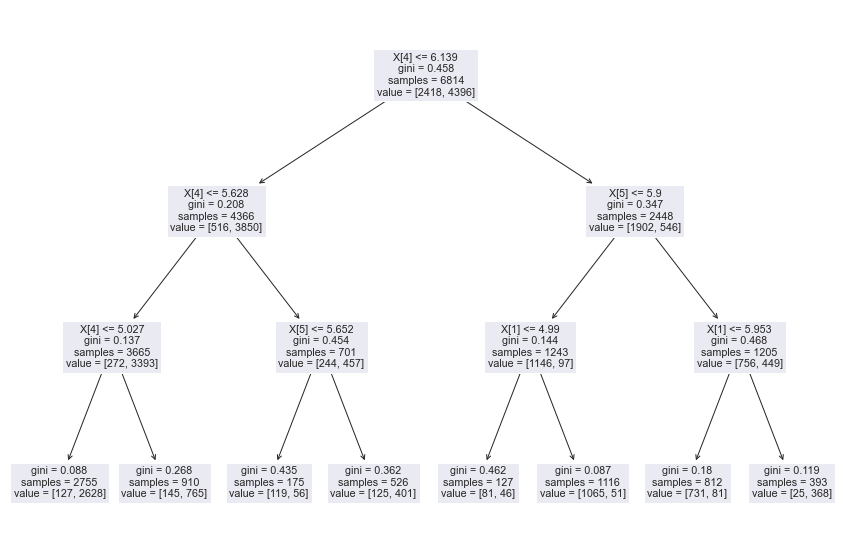

In [24]:
tree.plot_tree(clean_clf);

In [25]:
for i in list([1, 4, 5]):
    print(X_train_clean.columns[i])

trombocyty
hbver
hematokrit


Opäť si skúsime natrénovať 20 modelov s maximálnou hĺbkou od 1 do 20 a vidíme, že presnosť je v tomto prípade oveľa vyššia. Treba však brať do úvahy, že v tomto datasete je 26 stĺpcov, pričom v predošlom je iba 5, teda sme ušetrili obrovské množstvo dát. To sa môže prejaviť pri oveľa väčších datasetov, ktorých modely je potrebné trénovať niekoľko hodín. V takom prípade je samozrejme lepšie vybrať iba časť datasetu, aby sa trénovací a predikčný čas čo najviac skrátil a aby presnosť priveľmi neklesla.

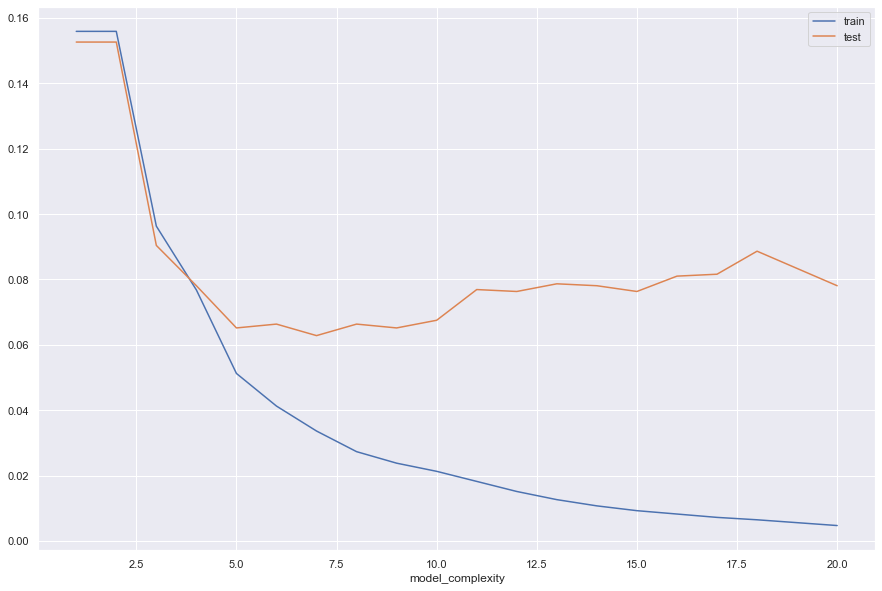

In [26]:
results = []
estimators = []
for i in range(1, 21):  
    row = {'model_complexity': i}
    clf = DecisionTreeClassifier(max_depth = i, random_state=0) 
    
    pred = clf.fit(X_train_clean, y_train_clean).predict(X_train_clean) 
    row['train'] = 1 - accuracy_score(y_train_clean, pred) 
    
    pred = clf.predict(X_test_clean)
    row['test'] = 1 - accuracy_score(y_test_clean, pred) 
    results.append(row)
    estimators.append(clf)
    
complexity_df = pd.DataFrame(results).plot(x='model_complexity')

Aj na tomto datasete môžeme skúsiť `GridSearch` s rovnakými parametrami ako pri zmenšenom datasete. V tomto prípade nám vyšlo, že najlepší model používa entropy funkciu a maximálnu hĺbku až 7. Skúsime si teda tento model vyhodnotiť tak, ako pri testovaní `RandomForest`. V tomto prípade sme už konečne presiahli 90% pre každú metriku a cross-validácia taktiež ukazuje priemernú presnosť 91% s odchýlkou 2%.

In [27]:
parameters = {'criterion': ['gini', 'entropy'],
              'splitter': ['best', 'random'],
              'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]}

dtc = DecisionTreeClassifier()
clf = GridSearchCV(dtc, parameters, scoring='accuracy', cv=5)
clf.fit(X_train_clean, y_train_clean)

clf.best_params_

{'criterion': 'entropy', 'max_depth': 8, 'splitter': 'best'}

In [28]:
pred = clf.best_estimator_.predict(X_test_clean)

print('Accuracy:', accuracy_score(y_test_clean, pred))
print('Precision:', precision_score(y_test_clean, pred))
print('Recall:', recall_score(y_test_clean, pred))

Accuracy: 0.9342723004694836
Precision: 0.9418710263396912
Recall: 0.9557603686635945


In [29]:
scores = cross_val_score(clf.best_estimator_, X_test_clean, y_test_clean, cv=10)
print("Presnost %0.2f so standardnou odchylkou %0.2f" % (scores.mean(), scores.std()))

Presnost 0.90 so standardnou odchylkou 0.02


Tento model teda môžeme označiť za najpresnejší, ale čo ak overfittuje? Opäť si teda vykreslíme chybovosť na trénovacom a testovacom datasete a môžeme pozorovať, že chybovosť je výrazne nižšia ako pri zmenšenom datasete.

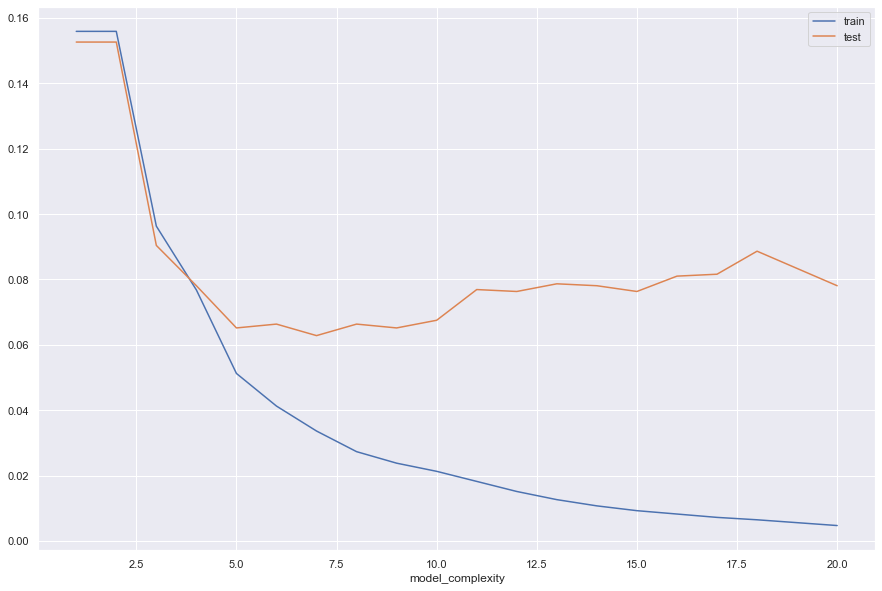

In [30]:
results = []
estimators = []
for i in range(1, 21):  
    row = {'model_complexity': i}
    clf = DecisionTreeClassifier(max_depth = i, random_state=0) 
    
    pred = clf.fit(X_train_clean, y_train_clean).predict(X_train_clean) 
    row['train'] = 1 - accuracy_score(y_train_clean, pred) 
    
    pred = clf.predict(X_test_clean)
    row['test'] = 1 - accuracy_score(y_test_clean, pred) 
    results.append(row)
    estimators.append(clf)
    
complexity_df = pd.DataFrame(results).plot(x='model_complexity')

## Tvorba pipeline

Teraz skúsime vytvoriť pipeline, ktorá najprv transformuje, a potom urobí trénovanie (alebo predikciu) modelu. Rovnako ako v druhej fáze, vytvoríme si samostatné pipeline na numerické a kategorické atribúty. Následne si vyberieme názvy stĺpcov, ktoré sú numerické a kategorické, a tieto stĺpce použijeme v ColumnTransformeri aby vedel, na ktorý atribút aplikovať aké operácie.

In [31]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

numeric_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='mean')),
    ('scale', MinMaxScaler())
])

categorical_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('one-hot', OneHotEncoder(handle_unknown='ignore', sparse=False))
])

numeric_features = X_train_clean.select_dtypes(include='number').columns.tolist()
categoric_features = X_train_clean.select_dtypes(exclude='number').columns.tolist()

full_processor = ColumnTransformer(transformers=[
    ('number', numeric_pipeline, numeric_features),
    ('category', categorical_pipeline, categoric_features)
])

Následne tento preprocessor vložíme do ďalšej pipeline zakončenej rozhodovacím stromom, takže vložené dáta budú automaticky transformované a aj použité v modeli. Model najprv natrénujeme na trénovacích dátach z kompletného datasetu pomocou `fit()` a následne môžeme použiť `score()` na získanie presnosti modelu. Ak chceme prezerať aj ostatné metriky, môžeme použiť `predict()`.

Tu môžeme sledovať zaujímavý výsledok - model sa transformáciami zhoršil. Nie veľmi, rozdiel je veľmi malý, ale napriek tomu je možné, že transformácia dát v tomto prípade škodí.

In [32]:
clf = Pipeline(steps=[
    ("preprocessor", full_processor), 
    ("classifier", DecisionTreeClassifier(max_depth=7, random_state=42))
])

clf.fit(X_train_clean, y_train_clean)
clf.score(X_test_clean, y_test_clean)

0.9348591549295775

In [33]:
pred = clf.predict(X_test_clean)

print('Accuracy:', accuracy_score(y_test_clean, pred))
print('Precision:', precision_score(y_test_clean, pred))
print('Recall:', recall_score(y_test_clean, pred))

Accuracy: 0.9348591549295775
Precision: 0.9427272727272727
Recall: 0.9557603686635945


In [34]:
scores = cross_val_score(clf, X_test_clean, y_test_clean, cv=10)
print("Presnost %0.2f so standardnou odchylkou %0.2f" % (scores.mean(), scores.std()))

Presnost 0.91 so standardnou odchylkou 0.02


Môžeme teda vyskúšať odstrániť niektorý krok z transformácie, v prvom prípade skúsime odstrániť OneHotEncoding a vidíme, že výsledky sú identické. Pri cross-validácii však môžeme vidieť, že výsledok je o 2% lepší.

In [35]:
numeric_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='mean')),
    ('scale', MinMaxScaler())
])

categorical_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='most_frequent'))
])

full_processor = ColumnTransformer(transformers=[
    ('number', numeric_pipeline, numeric_features),
    ('category', categorical_pipeline, categoric_features)
])

clf2 = Pipeline(steps=[
    ("preprocessor", full_processor), 
    ("classifier", DecisionTreeClassifier(max_depth=7, random_state=42))
])

clf2.fit(X_train_clean, y_train_clean)
pred = clf2.predict(X_test_clean)

print('Accuracy:', accuracy_score(y_test_clean, pred))
print('Precision:', precision_score(y_test_clean, pred))
print('Recall:', recall_score(y_test_clean, pred))

Accuracy: 0.9348591549295775
Precision: 0.9427272727272727
Recall: 0.9557603686635945


In [36]:
scores = cross_val_score(clf2, X_test_clean, y_test_clean, cv=10)
print("Presnost %0.2f so standardnou odchylkou %0.2f" % (scores.mean(), scores.std()))

Presnost 0.91 so standardnou odchylkou 0.02


Následne skúsime odstrániť škálovanie numerických atribútov. Výsledky dopadli rovnako ako pri predošlom pokuse, takže možno transformácie nakoniec až taký vplyv na presnosť modelu nemajú.

In [37]:
numeric_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='mean'))
])

categorical_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('one-hot', OneHotEncoder(handle_unknown='ignore', sparse=False))
])

full_processor = ColumnTransformer(transformers=[
    ('number', numeric_pipeline, numeric_features),
    ('category', categorical_pipeline, categoric_features)
])

clf3 = Pipeline(steps=[
    ("preprocessor", full_processor), 
    ("classifier", DecisionTreeClassifier(max_depth=7, random_state=42))
])

clf3.fit(X_train_clean, y_train_clean)
pred = clf3.predict(X_test_clean)

print('Accuracy:', accuracy_score(y_test_clean, pred))
print('Precision:', precision_score(y_test_clean, pred))
print('Recall:', recall_score(y_test_clean, pred))

Accuracy: 0.9348591549295775
Precision: 0.9427272727272727
Recall: 0.9557603686635945


In [38]:
scores = cross_val_score(clf3, X_test_clean, y_test_clean, cv=10)
print("Presnost %0.2f so standardnou odchylkou %0.2f" % (scores.mean(), scores.std()))

Presnost 0.91 so standardnou odchylkou 0.02


# Zhrnutie

Zhodnotiť nami natrénované modely nie je tak jednoduché ako by sa mohlo spočiatku zdať. Rozdiely medzi jednotlivými modelmi vyšli relatívne malé a samotnú presnosť sa nám nepodarilo dostať nad hranicu 90%.

### Model s vybranými atribútmi


**Najvyššiu presnosť (accuracy)** dosiahol **RandomForestClassifier** s úspešnosťou **0.8615023474178404**

**Najlepší recall** má **DecisionTreeClassifier** s úspešnosťou **0.9188940092165898**

**Najlepšiu precíznosť** má **One-rule algoritmus** s úspešnosťou **0.9047263681592039**

Ak máme teda označiť jeden z modelov ako najlepší, môžme postupovať poďľa výsledku celkovej presnosti (accuracy). Táto hodnota nie je jedinou smerodajnou hodnotou, no hovorí o tom, v koľkých prípadoch z celkového počtu klasifikácií správne predikoval výslednú hodnotu premennej `indicator`

Podľa parametru **accuracy** nám ako najlepší model v našom projekte vyšiel **RandomForestClassifier**, kde sme si pomocou `GridSearchCV` zároveň našli aj najlepšie parametre pre tento klasifikátor, ktoré nám určilo ako: `klasifikátor s bootstrap, entropy funkciou, maximálnou hĺbkou 5 a počtom stromov 100`.

Na vyhodnotenie modelov sme používali vyššie spomínané metriky klasifikačnej evaluácie, spomínané vyššie (Accuracy, Precision, Recall). Taktiež sme používali aj cross-validáciu a presnoť pomocou nej, a taktiež štandardnú odchýľku.

Zo samotných dát sme ako indikátory vo finálnych 'zjednodušených' modeloch používali 5 indikátorov ktorými boli (zoradené podľa dôležitosti): 
1. hbver
2. hematokrit
3. weight
4. er-cv
5. hemoglobin


### Model s kompletnými dátami


Nakoniec sme si skúsili vytvoriť a pracovať aj s modelmi ktoré pracovali s kompletnými dátami a ktoré v nejakej forme obsahovali všetky z pôvodných atribútov. Pri tomto modeli pracujúcom s kompletnými dátami sme si pomocou DecisionTreeClassifier dosiahli hodnoty:
**Accuracy: 0.9096244131455399**
**Precision: 0.9130434782608695**
**Recall: 0.9483870967741935**

Prekonali sme teda pomyselnú hranicu 90%, no tento model pracuje so všetkými parametrami, čo sa môže časovo nagatívne prejaviť pri trénovaní a behu na veľkom množstve dát. Skúsili sme tento model potiahnuť ešte ďalej, a pomocou `GridSearchCV` sme zistili, že ideálnymi hodnotami pre tento model sú `{'criterion': 'entropy', 'max_depth': 7, 'splitter': 'best'}`

Po cross-validácií sme dostali presnosť 0.91 so štandardnou odchýlkou 0.02
Tento model teda môžeme označiť za najpresnejší, no teoreticky by mohol overfittovať. Vykreslili sme si teda chybovosť na trénovacom a testovacom datasete pozorovali sme, že chybovosť je výrazne nižšia ako pri zmenšenom datasete s menším počtom atribútov. 

Pri práci s modelom s kompletnými dátami sme pozorovali niečo nezvyčajné - model sa transformáciami zhoršil. Rozdiel bol však malý, no napriek tomu je možné, že transformácia dát v tomto prípade škodí, čo sme si overili ešte postupným odstraňovaním časti transformácie. Najprv sme skúsili odstrániť OneHotEncoding a zistili sme že výsledky vyšli totožné. Pri cross-validácii nám však vyšiel výsledok lepší o 2%. Potom sme skúsili odstrániť škálovanie numerických atribútov, kde nám výsledky dopadli porobne ako pri odstraňovaní OneHotEncoding, z čoho môžme pravdepodobne vyvodiť že transformácie nemusia mať až taký výrazný vplyv na presnosť modelu.

